# Calibration example

In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from pathlib import Path
from scipy.stats import bootstrap
from radiocalibrationtoolkit import *

In [2]:
# some ad-hoc plotting functions

def statistic_without_nans(col, func):
    if func is not None:
        return func(col.dropna())
    else:
        raise ValueError("Invalid function argument.")
    
def calculate_and_plot_with_true(df_true_sim_file_path, power_rec_DF):
    power_sim_true_DF = pd.read_csv(df_true_sim_file_path[0], index_col=0)
    power_sim_true_DF.columns = power_sim_true_DF.columns.astype(float)

    frequencies_MHz = power_sim_true_DF.columns.values
    slopes = []
    intercepts = []
    for i, freq in enumerate(power_sim_true_DF.columns):
        x_arr = power_sim_true_DF.loc[:, freq].values
        y_arr = power_rec_DF.loc[:, freq].values
        intercept, slope = robust_regression(x_arr, y_arr)
        intercepts.append(intercept)
        slopes.append(slope)

    intercepts = np.asarray(intercepts) ** (1 / 2)
    slopes = np.asarray(slopes) ** (1 / 2)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(Path(df_true_sim_file_path[0]).stem)
    ax[0].plot(frequencies_MHz, (slopes), marker="o", linestyle="")
    median = np.median(slopes[~np.isnan(slopes)])
    ax[0].axes.axhline(median, label="median={:.2f}".format(median), color="red")
    ax[0].set_ylim(0.8, 1.2)
    ax[0].set_xlabel("frequency [MHz]")
    ax[0].set_ylabel("voltage \ncalibration parameter")
    ax[0].xaxis.set_major_locator(MultipleLocator(10))
    ax[0].legend()
    ax[1].bar(frequencies_MHz, intercepts, width=1)
    # ax[1].set_ylim(0, 5)
    ax[1].set_xlabel("frequency [MHz]")
    ax[1].set_ylabel("voltage \nnoise offset ")
    ax[1].xaxis.set_major_locator(MultipleLocator(10))

    fig.subplots_adjust(wspace=0.3, bottom=0.2)


def get_slope_and_intercepts_dfs(concatenated_df, power_rec_DF):
    slopes_dict = {}
    intercepts_dict = {}

    for key in concatenated_df.index.levels[0]:
        power_sim_DF = concatenated_df.xs(key)
        frequencies_MHz = power_sim_DF.columns.values

        slopes = []
        intercepts = []
        for i, freq in enumerate(power_sim_DF.columns):
            x_arr = power_sim_DF.loc[:, freq].values
            y_arr = power_rec_DF.loc[:, freq].values

            intercept, slope = robust_regression(x_arr, y_arr)
            intercepts.append(intercept)
            slopes.append(slope)

        slopes_dict[key] = np.asarray(slopes) ** (1 / 2)
        intercepts_dict[key] = np.asarray(intercepts) ** (1 / 2)

    slopes_DF = pd.DataFrame(slopes_dict).T
    slopes_DF.columns = power_sim_DF.columns
    intercepts_DF = pd.DataFrame(intercepts_dict).T
    intercepts_DF.columns = power_sim_DF.columns

    return slopes_DF, intercepts_DF


def bounds_from_slope_DF(slopes_DF, stat_func):
    bounds = []
    for col in slopes_DF.columns:
        boot_res = bootstrap(
            (slopes_DF.loc[:, col].values,),
            stat_func,
            n_resamples=1000,
            confidence_level=0.68,
            method="BCa",
        )
        bounds.append(
            (boot_res.confidence_interval.low, boot_res.confidence_interval.high)
        )
    bounds = np.asarray(bounds).T
    freq_dependent_slopes = slopes_DF.apply(statistic_without_nans, args=(stat_func,))
    return freq_dependent_slopes, bounds


def plot_results_with_CI(slopes_DF, intercepts_DF, title="", labels=None):
    # calculate
    stat_func = np.mean
    stat = "mean"

    freq_dependent_slopes, bounds = bounds_from_slope_DF(slopes_DF, stat_func)

    # this needs to be median, because at some frequencies there can be strong outliers
    total_central_value = freq_dependent_slopes.median()
    boot_res = bootstrap(
        (freq_dependent_slopes.values,),
        np.median,
        n_resamples=1000,
        confidence_level=0.68,
        method="BCa",
    )
    bounds_total_central_value = (
        boot_res.confidence_interval.low,
        boot_res.confidence_interval.high,
    )

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title)

    if labels == None:
        glabels = [k.split("_")[1] for k in slopes_DF.index.values]
    else:
        glabels = labels
    ax[0].plot(
        frequencies_MHz, slopes_DF.values.T, linestyle="-", alpha=0.1
    )  # , label=glabels)
    ax[0].plot(
        frequencies_MHz, slopes_DF.values.T, marker="o", linestyle="", markersize=3
    )  # , label=glabels)

    ax[0].plot(
        freq_dependent_slopes.index.values, freq_dependent_slopes.values, label=stat
    )
    ax[0].fill_between(
        frequencies_MHz,
        bounds[0,],
        bounds[1,],
        alpha=0.3,
        label="68% CI",
    )

    ax[0].set_xlabel("frequency [MHz]")
    ax[0].set_ylabel("voltage \ncalibration parameter")

    ax[0].axes.axhline(
        total_central_value,
        color="grey",
        lw=3,
        label="Me(CP(f))={:.2f}".format(total_central_value),
    )
    ax[0].axes.axhspan(
        bounds_total_central_value[0],
        bounds_total_central_value[1],
        color="grey",
        alpha=0.3,
        label="68% CI",
    )
    ax[0].legend(fontsize=12)

    ax[1].plot(frequencies_MHz, intercepts_DF.values.T, label=glabels)
    ax[1].set_ylim(0, 5)
    ax[1].set_xlabel("frequency [MHz]")
    ax[1].set_ylabel("voltage \nnoise offset ")
    ax[1].xaxis.set_major_locator(MultipleLocator(10))
    ax[1].legend(fontsize=12, ncol=2)

    fig.subplots_adjust(
        left=0.2,
        bottom=0.2,
        wspace=0.3,
    )
    
    return total_central_value


In [3]:
# This ensures Plotly output works in multiple places:
# plotly_mimetype: VS Code notebook UI
# notebook: "Jupyter: Export to HTML" command in VS Code
# See https://plotly.com/python/renderers/#multiple-renderers
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

In [4]:
# some global plot settings
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 14

plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2

plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5

plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

In [5]:
# for this example you need to create a mock power dataframe and simulated sidereal power dataset

## Calibrate with "true"

In [6]:
# in this case the recorded is the mock dataset
power_rec_DF = pd.read_csv(
    # "./mock_power_datasets/mock_power_dataset-Salla_EW_GSM16_N10000_temp30.0C_0.0additionalnoise_rounding-True.csv",
    "./mock_power_datasets/mock_power_dataset-Salla_EW_GSM16_N10000_temp-10_50C_0.0additionalnoise_rounding-True.csv",
    index_col=0,
)

# power_rec_DF.iloc[:, :] = power_rec_DF.values
# power_rec_DF = power_rec_DF.iloc[:, 30:80]
power_rec_DF.columns = power_rec_DF.columns.astype(float)

dir_path = "./simulated_power_datasets/"
df_files = [
    os.path.join(dir_path, i) for i in os.listdir(dir_path) if (i.endswith(".csv") & i.startswith('Salla'))
]
power_sim_DF = pd.read_csv(df_files[-3], index_col=0)
# power_sim_DF.iloc[:, :] = power_sim_DF.values
power_sim_DF.columns = power_sim_DF.columns.astype(float)

In [7]:
df_files[-3]

'./simulated_power_datasets/Salla_GSM16.csv'

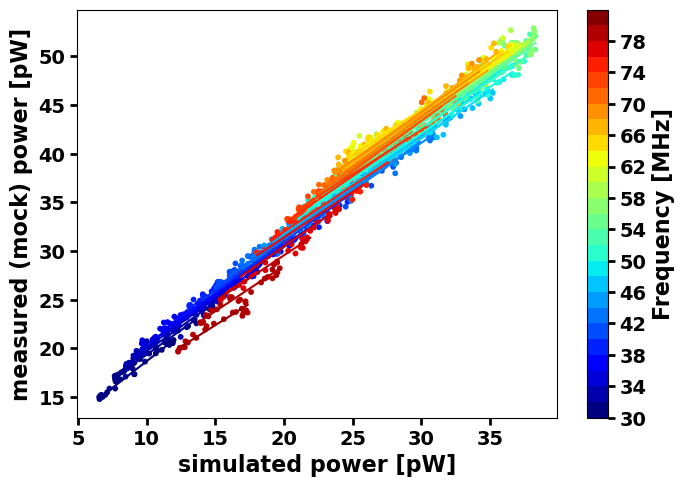

In [8]:
# fit each band and make a plot overview
cmapT = plt.get_cmap("jet")
bounds = np.arange(30, 83, 2)
norm = mpl.colors.BoundaryNorm(bounds, cmapT.N)

fig, ax = plt.subplots(figsize=(8, 6))

frequencies_MHz = power_sim_DF.columns.values
slopes = []
intercepts = []
for i, freq in enumerate(power_sim_DF.columns):
    c = [freq] * power_rec_DF.index.size
    x_arr = power_sim_DF.loc[:, freq].values
    y_arr = power_rec_DF.loc[:, freq].values
    cs = ax.scatter(x_arr, y_arr, s=10, c=c, norm=norm, cmap="jet")

    intercept, slope = robust_regression(x_arr, y_arr)
    intercepts.append(intercept)
    slopes.append(slope)
    x_new = np.linspace(np.min(x_arr), np.max(x_arr), 100)
    ax.plot(
        x_new,
        x_new * slope + intercept,
        color=cmapT((freq - np.min(bounds)) * (bounds[1] - bounds[0]) / 100),
    )

intercepts = np.asarray(intercepts) ** (1 / 2)
slopes = np.asarray(slopes) ** (1 / 2)

cbar = fig.colorbar(cs, ticks=np.arange(30, 81, 4), ax=ax)
cbar.set_label("Frequency [MHz]")
ax.set_xlabel("simulated power [pW]")
ax.set_ylabel("measured (mock) power [pW]")
fig.subplots_adjust(left=0.15, bottom=0.2)

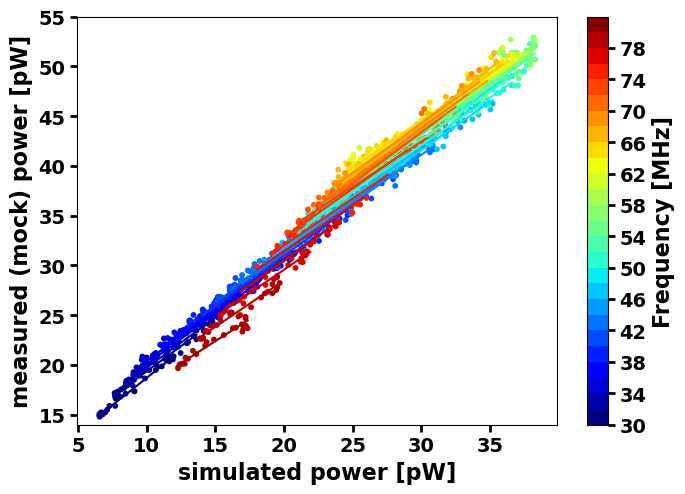

In [9]:
fig_data = pickle.dumps(fig)
fig2 = pickle.loads(fig_data)

# modify the axis limits of the copied figure
ax2 = fig2.axes
ax2[0].set_ylim(14, 55)
fig2

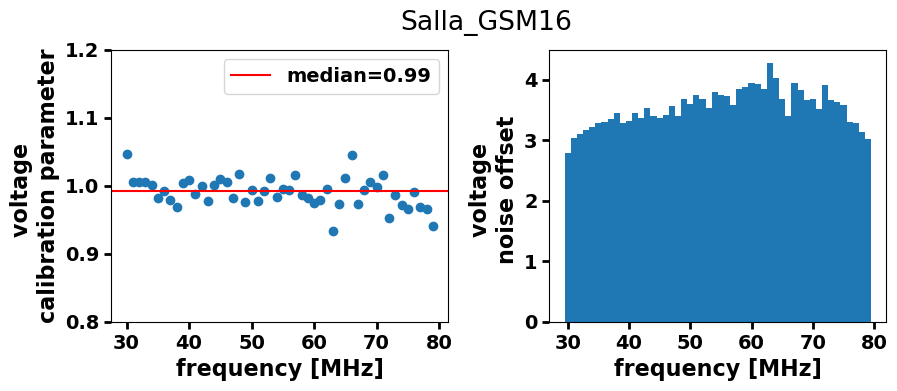

In [10]:


calculate_and_plot_with_true([(df_files[-3])], power_rec_DF)

## Calibrate with all 'not true' simulated datasets

In [11]:
df_list = []
df_names = []
except_this = 'Salla_GSM16'
for f in df_files:
    if except_this not in f:
        df = pd.read_csv(f, index_col=0)
        df.columns = df.columns.astype(float)
        df_list.append(df)
        df_names.append(Path(f).stem)

concatenated_sim_df = pd.concat(df_list, keys=df_names)
# check keys
[key for key in concatenated_sim_df.index.levels[0]]

['Salla_GMOSS',
 'Salla_SSM',
 'Salla_Haslam',
 'Salla_LFSS',
 'Salla_ULSA',
 'Salla_GSM08',
 'Salla_LFmap']

In [12]:
slopes_DF, intercepts_DF = get_slope_and_intercepts_dfs(concatenated_sim_df, power_rec_DF)

0.935816948375442

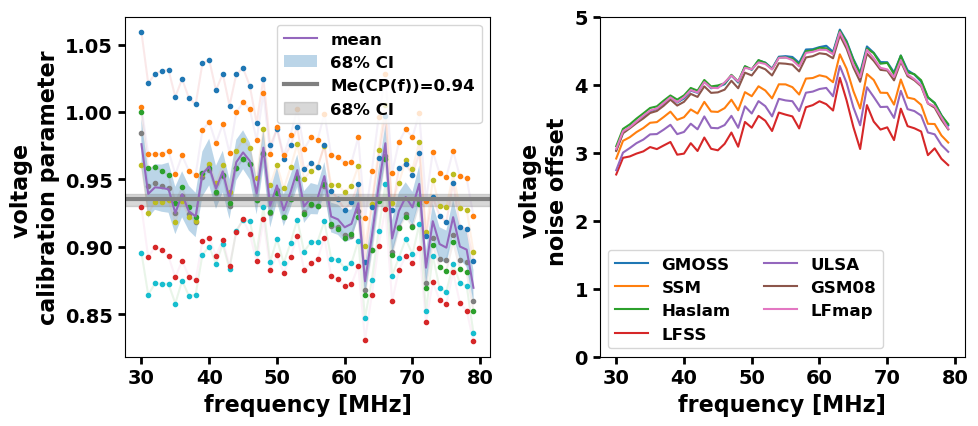

In [13]:
plot_results_with_CI(slopes_DF, intercepts_DF, title="")


## Iteratively apply the previous procedure to all simulated datasets

In [14]:
# for this example you need to create a mock power dataframe and simulated sidereal power dataset

In [15]:
# plot results
def calculate_and_plot_results(df_sim_files, df_mock_files, df_true_sim_file_path):
    print(df_sim_files, df_mock_files, df_true_sim_file_path)
    # calculate
    # read in all simulated datasets except the "true" one
    df_list = []
    df_names = []
    for f in df_sim_files:
        df = pd.read_csv(f, index_col=0)
        df.columns = df.columns.astype(float)
        df_list.append(df)
        df_names.append(Path(f).stem)

    concatenated_sim_df = pd.concat(df_list, keys=df_names)
    # read-in rec dataset
    power_rec_DF = pd.read_csv(
        df_mock_files[0],
        index_col=0,
    )
    power_rec_DF.columns = power_rec_DF.columns.astype(float)

    # fitted with all others
    slopes_DF, intercepts_DF = get_slope_and_intercepts_dfs(
        concatenated_sim_df, power_rec_DF
    )
    median = plot_results_with_CI(slopes_DF, intercepts_DF, title="True: {}".format(gmodel))
    # fitted with True
    calculate_and_plot_with_true(df_true_sim_file_path, power_rec_DF)

    return slopes_DF, intercepts_DF, median

['./simulated_power_datasets/Salla_GMOSS.csv', './simulated_power_datasets/Salla_SSM.csv', './simulated_power_datasets/Salla_Haslam.csv', './simulated_power_datasets/Salla_LFSS.csv', './simulated_power_datasets/Salla_ULSA.csv', './simulated_power_datasets/Salla_GSM08.csv', './simulated_power_datasets/Salla_LFmap.csv'] ['./mock_power_datasets/mock_power_dataset-Salla_EW_GSM16_N10000_temp-10_50C_0.0additionalnoise_rounding-True.csv'] ['./simulated_power_datasets/Salla_GSM16.csv']


['./simulated_power_datasets/Salla_GMOSS.csv', './simulated_power_datasets/Salla_SSM.csv', './simulated_power_datasets/Salla_Haslam.csv', './simulated_power_datasets/Salla_ULSA.csv', './simulated_power_datasets/Salla_GSM16.csv', './simulated_power_datasets/Salla_GSM08.csv', './simulated_power_datasets/Salla_LFmap.csv'] ['./mock_power_datasets/mock_power_dataset-Salla_EW_LFSS_N10000_temp-10_50C_0.0additionalnoise_rounding-True.csv'] ['./simulated_power_datasets/Salla_LFSS.csv']


['./simulated_power_datasets/Salla_GMOSS.csv', './simulated_power_datasets/Salla_SSM.csv', './simulated_power_datasets/Salla_Haslam.csv', './simulated_power_datasets/Salla_LFSS.csv', './simulated_power_datasets/Salla_ULSA.csv', './simulated_power_datasets/Salla_GSM16.csv', './simulated_power_datasets/Salla_LFmap.csv'] ['./mock_power_datasets/mock_power_dataset-Salla_EW_GSM08_N10000_temp-10_50C_0.0additionalnoise_rounding-True.csv'] ['./simulated_power_datasets/Salla_GSM08.csv']


['./simulated_power_datasets/Salla_GMOSS.csv', './simulated_power_datasets/Salla_SSM.csv', './simulated_power_datasets/Salla_LFSS.csv', './simulated_power_datasets/Salla_ULSA.csv', './simulated_power_datasets/Salla_GSM16.csv', './simulated_power_datasets/Salla_GSM08.csv', './simulated_power_datasets/Salla_LFmap.csv'] ['./mock_power_datasets/mock_power_dataset-Salla_EW_Haslam_N10000_temp-10_50C_0.0additionalnoise_rounding-True.csv'] ['./simulated_power_datasets/Salla_Haslam.csv']


['./simulated_power_datasets/Salla_GMOSS.csv', './simulated_power_datasets/Salla_SSM.csv', './simulated_power_datasets/Salla_Haslam.csv', './simulated_power_datasets/Salla_LFSS.csv', './simulated_power_datasets/Salla_ULSA.csv', './simulated_power_datasets/Salla_GSM16.csv', './simulated_power_datasets/Salla_GSM08.csv'] ['./mock_power_datasets/mock_power_dataset-Salla_EW_LFmap_N10000_temp-10_50C_0.0additionalnoise_rounding-True.csv'] ['./simulated_power_datasets/Salla_LFmap.csv']


['./simulated_power_datasets/Salla_GMOSS.csv', './simulated_power_datasets/Salla_Haslam.csv', './simulated_power_datasets/Salla_LFSS.csv', './simulated_power_datasets/Salla_ULSA.csv', './simulated_power_datasets/Salla_GSM16.csv', './simulated_power_datasets/Salla_GSM08.csv', './simulated_power_datasets/Salla_LFmap.csv'] ['./mock_power_datasets/mock_power_dataset-Salla_EW_SSM_N10000_temp-10_50C_0.0additionalnoise_rounding-True.csv'] ['./simulated_power_datasets/Salla_SSM.csv']


['./simulated_power_datasets/Salla_SSM.csv', './simulated_power_datasets/Salla_Haslam.csv', './simulated_power_datasets/Salla_LFSS.csv', './simulated_power_datasets/Salla_ULSA.csv', './simulated_power_datasets/Salla_GSM16.csv', './simulated_power_datasets/Salla_GSM08.csv', './simulated_power_datasets/Salla_LFmap.csv'] ['./mock_power_datasets/mock_power_dataset-Salla_EW_GMOSS_N10000_temp-10_50C_0.0additionalnoise_rounding-True.csv'] ['./simulated_power_datasets/Salla_GMOSS.csv']


['./simulated_power_datasets/Salla_GMOSS.csv', './simulated_power_datasets/Salla_SSM.csv', './simulated_power_datasets/Salla_Haslam.csv', './simulated_power_datasets/Salla_LFSS.csv', './simulated_power_datasets/Salla_GSM16.csv', './simulated_power_datasets/Salla_GSM08.csv', './simulated_power_datasets/Salla_LFmap.csv'] ['./mock_power_datasets/mock_power_dataset-Salla_EW_ULSA_N10000_temp-10_50C_0.0additionalnoise_rounding-True.csv'] ['./simulated_power_datasets/Salla_ULSA.csv']


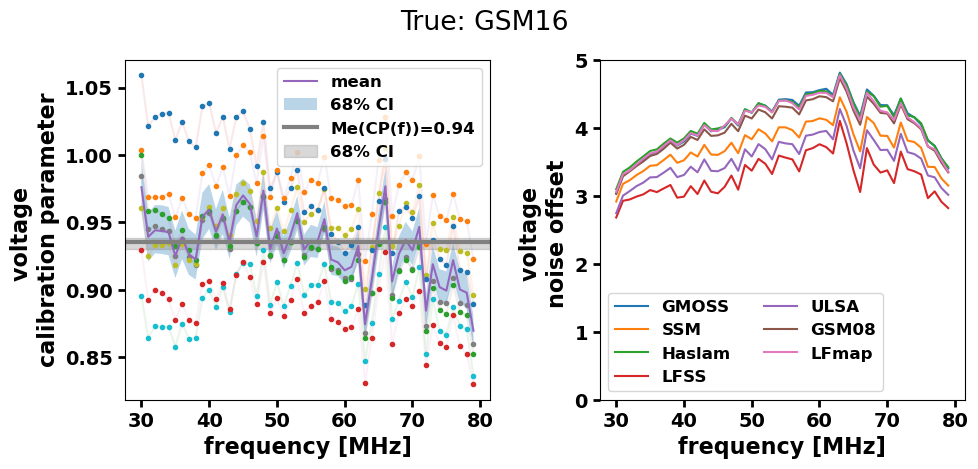

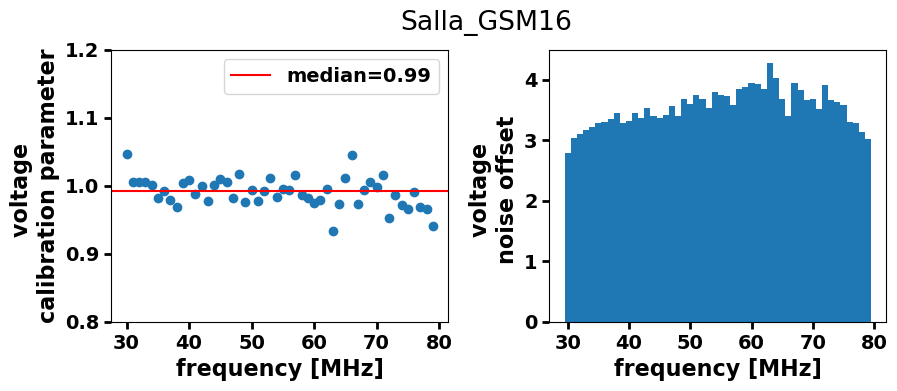

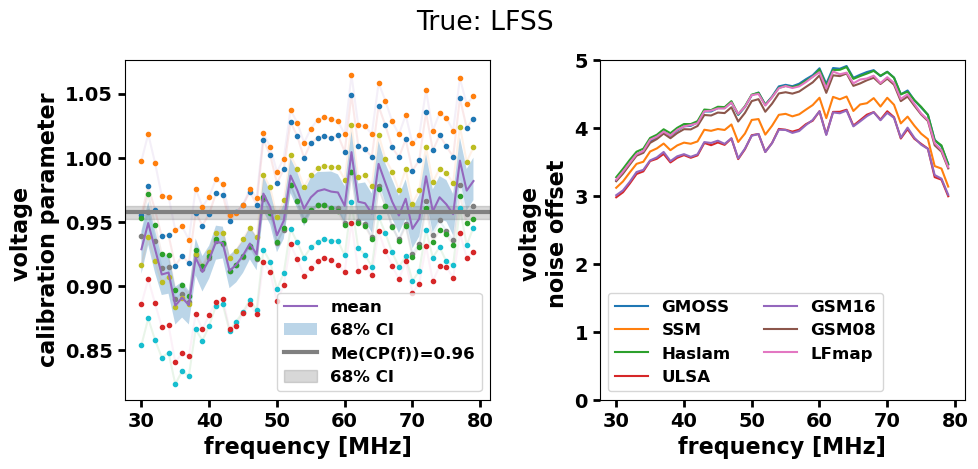

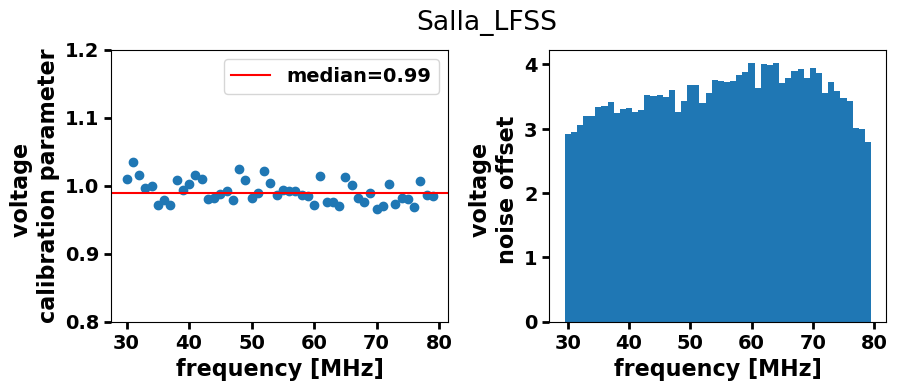

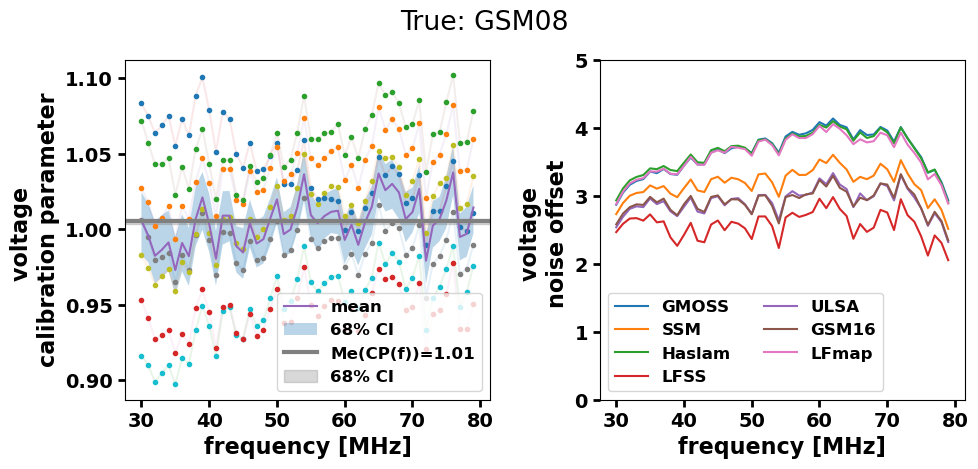

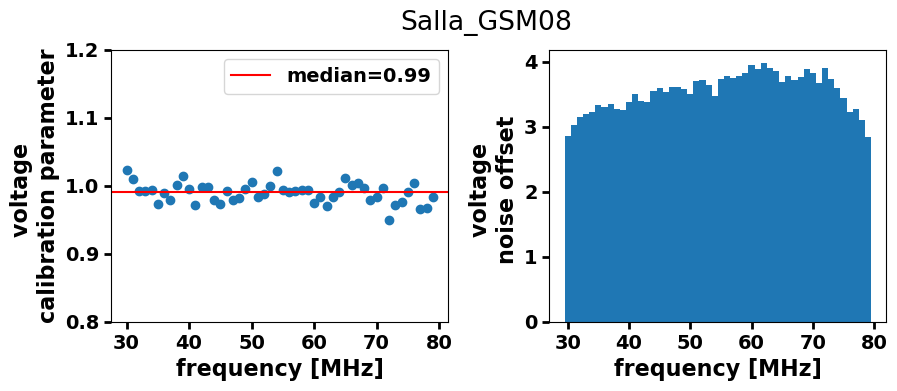

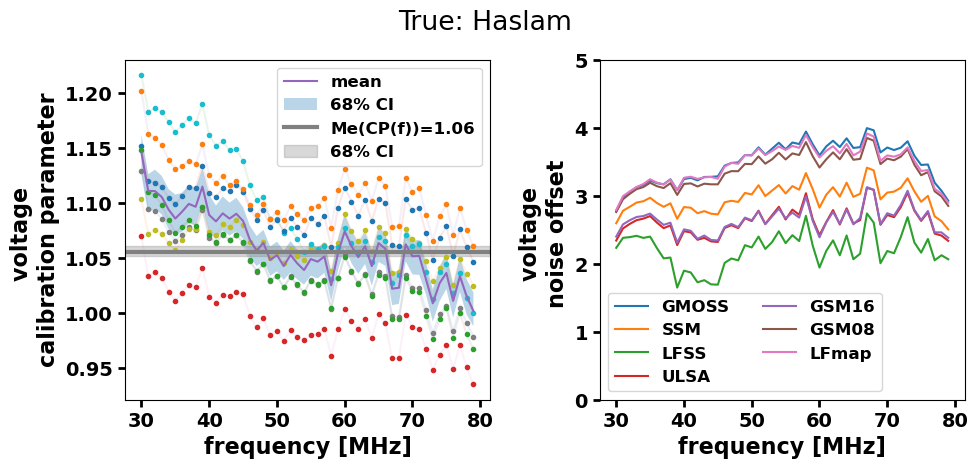

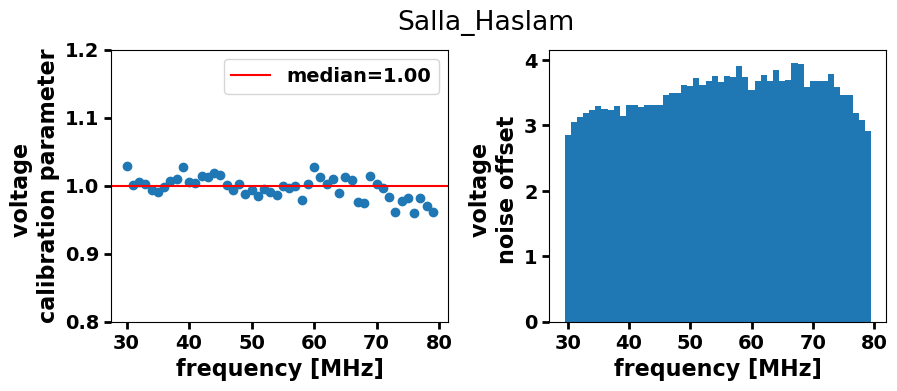

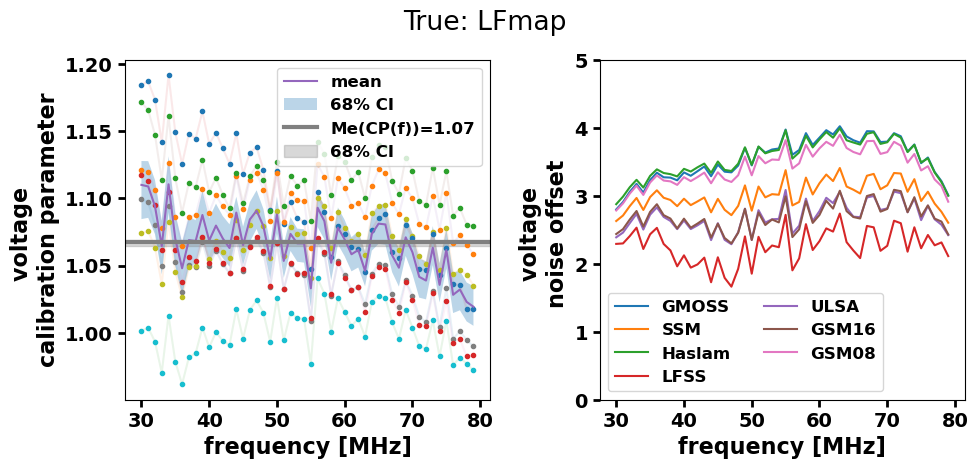

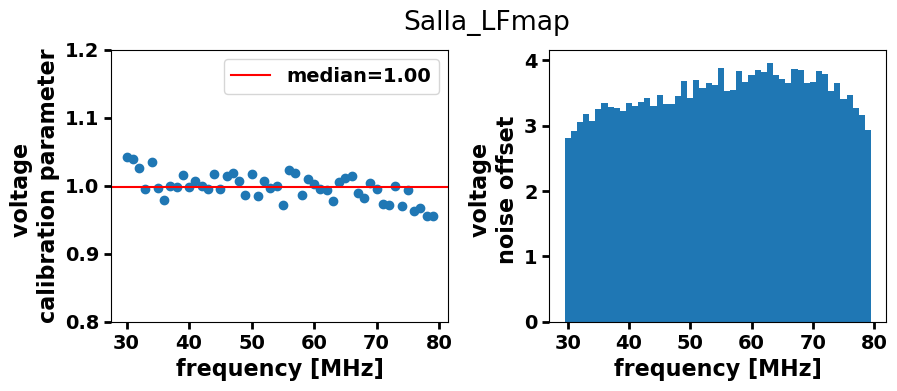

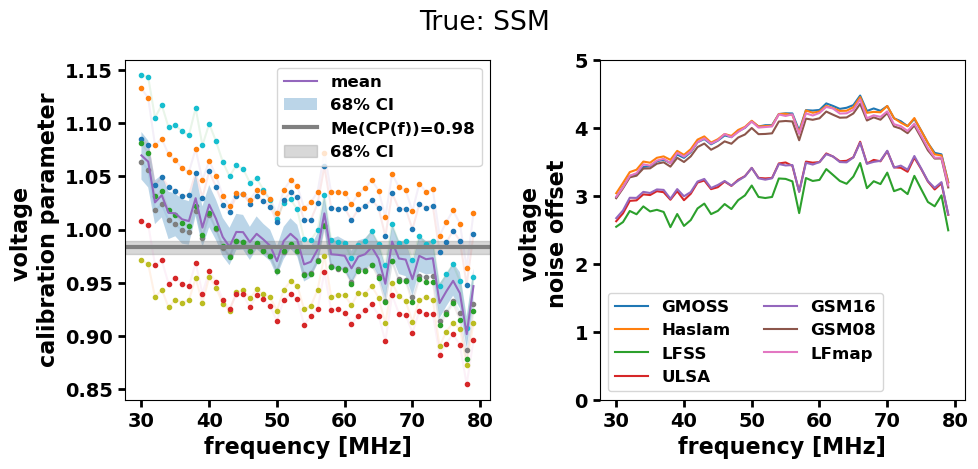

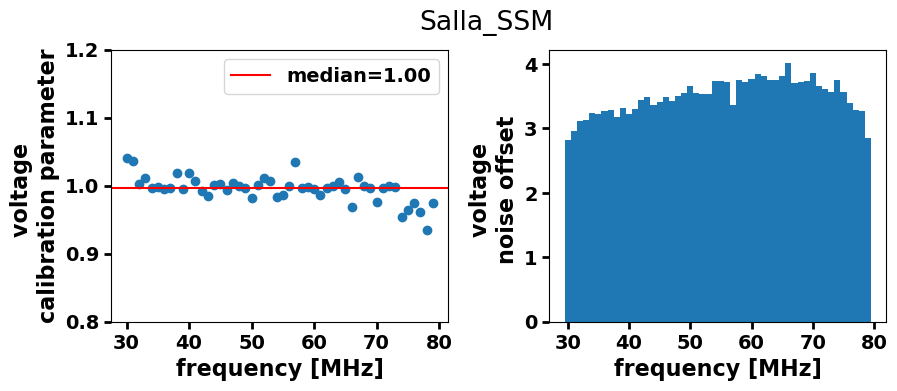

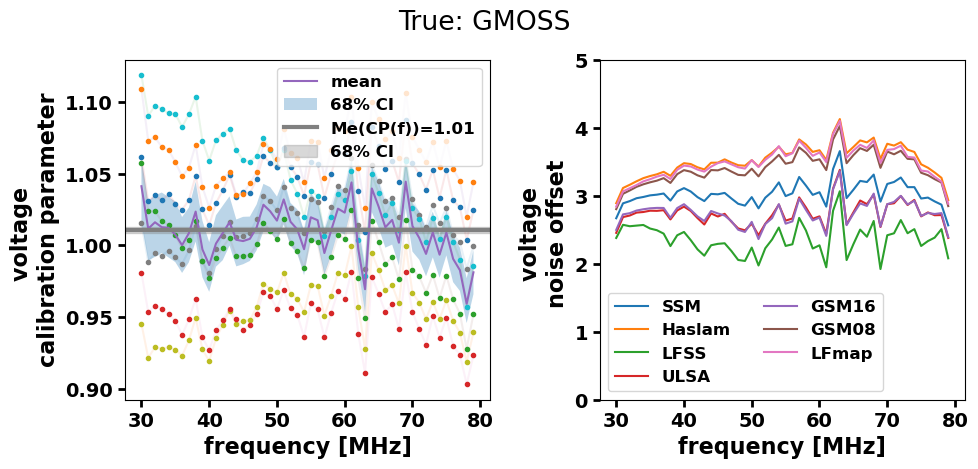

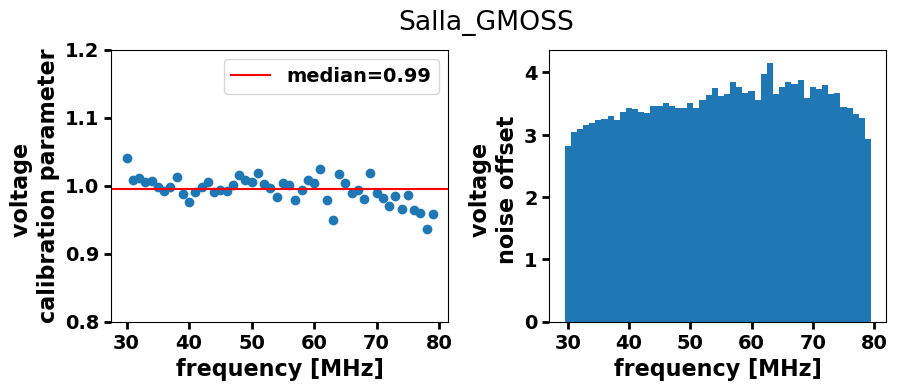

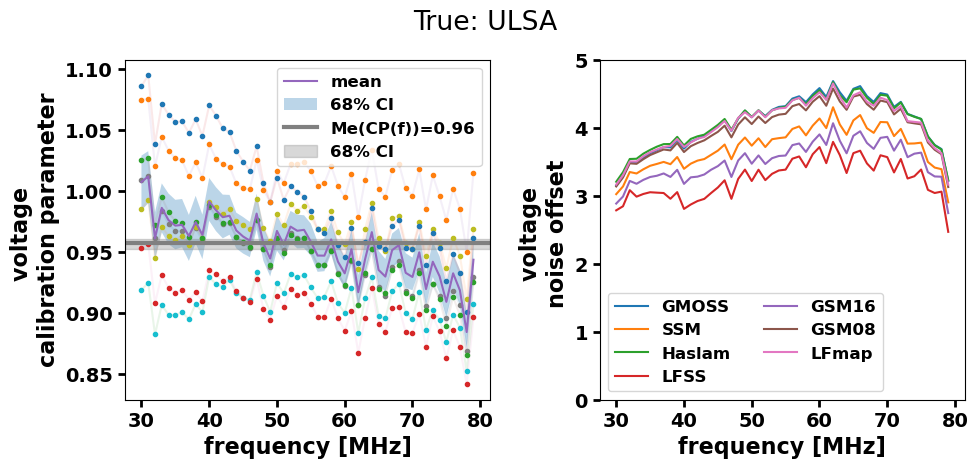

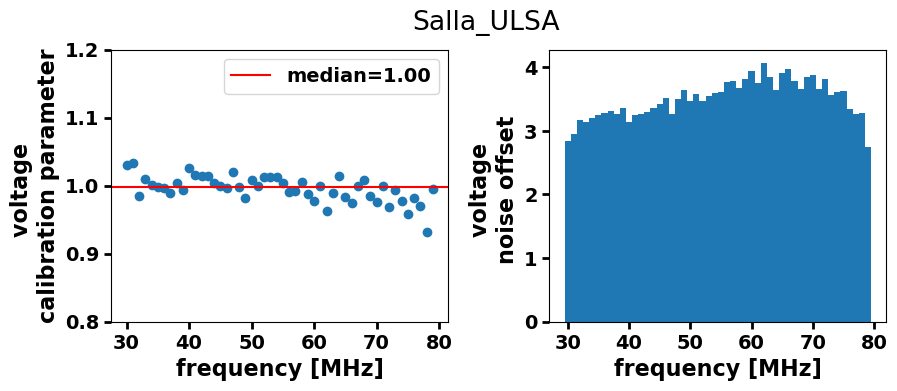

In [16]:
mock_datasets_path = "./mock_power_datasets/"
sim_datasets_path = "./simulated_power_datasets/"

galactic_models = [
    "GSM16",
    "LFSS",
    "GSM08",
    "Haslam",
    "LFmap",
    "SSM",
    "GMOSS",
    "ULSA",
]

pattern = "|".join(galactic_models)

antenna_model = "Salla"
all_slopes_dict = {}
all_intercepts_dict = {}
medians = np.array([])
for gmodel in galactic_models:
    temp_galactic_models = galactic_models.copy()
    temp_galactic_models.remove(gmodel)
    re_string_mock = r"{}.*{}.*N10000.*-10_50.*csv".format(antenna_model, gmodel)
    re_string_sim = r"{}.*{}.*csv".format(antenna_model, gmodel)

    df_mock_files = [
        os.path.join(mock_datasets_path, i)
        for i in os.listdir(mock_datasets_path)
        if re.search(re_string_mock, i)
    ]

    pattern = "|".join(
        ["^{}.*".format(antenna_model) + s for s in temp_galactic_models]
    )
    df_sim_files = [
        os.path.join(sim_datasets_path, i)
        for i in os.listdir(sim_datasets_path)
        if re.search(pattern, i) != None
    ]

    df_true_sim_file_path = [
        os.path.join(sim_datasets_path, i)
        for i in os.listdir(sim_datasets_path)
        if re.search(re_string_sim, i)
    ]
    all_slopes_dict[gmodel], all_intercepts_dict[gmodel], m = calculate_and_plot_results(df_sim_files, df_mock_files, df_true_sim_file_path)
    medians = np.append(medians, m)
    # here should be the function

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9981303170182356

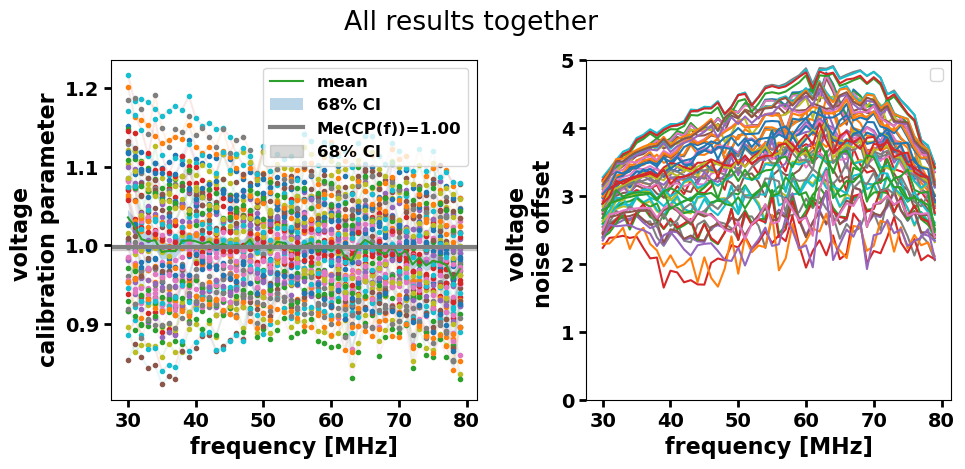

In [17]:
all_slopes_df = pd.concat(all_slopes_dict)
all_intercepts_df = pd.concat(all_intercepts_dict)

freq_dependent_slopes, bounds = bounds_from_slope_DF(all_slopes_df, np.mean)

plot_results_with_CI(all_slopes_df, all_intercepts_df, title="All results together", labels='')

0.935816948375442 1.067407868667611


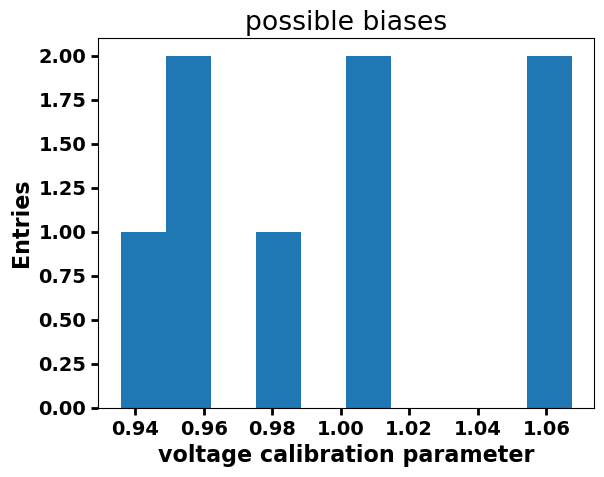

In [18]:
fig, ax = plt.subplots()

ax.set_title('possible biases')
ax.hist(medians)
ax.set_xlabel('voltage calibration parameter')
ax.set_ylabel('Entries')

print(np.min(medians), np.max(medians))

Text(0.05, 0.95, '$\\mu$=0.04')

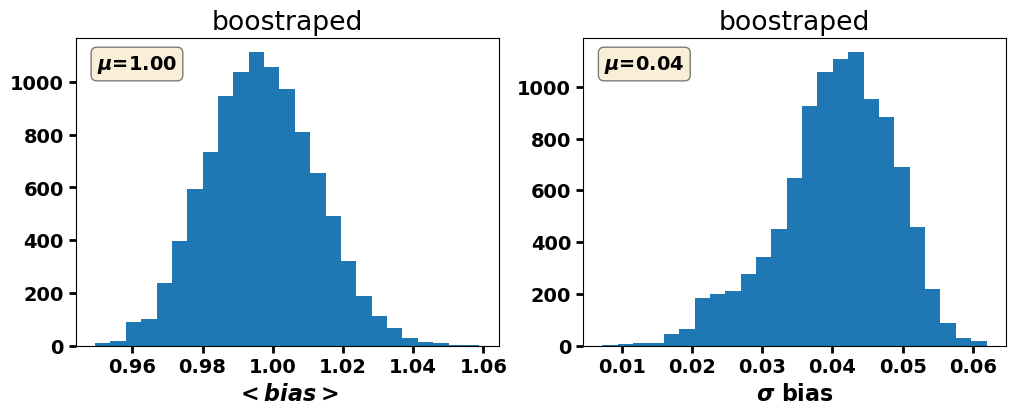

In [19]:
data = (medians,)  # samples must be in a sequence

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(1,2, figsize=(12,4))
res = bootstrap(data, np.mean, confidence_level=0.9)
bvalues = res.bootstrap_distribution
ax[0].hist(bvalues, bins=25)
ax[0].set_title('boostraped')
ax[0].set_xlabel(r'$<bias>$')
ax[0].text(0.05, 0.95, '$\mu$={:.2f}'.format(np.mean(bvalues)), transform=ax[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax[1].set_title('boostraped')
res = bootstrap(data, np.std, confidence_level=0.9)
bvalues = res.bootstrap_distribution
ax[1].hist(bvalues, bins=25)
ax[1].set_xlabel('$\sigma$ bias')
ax[1].text(0.05, 0.95, '$\mu$={:.2f}'.format(np.mean(bvalues)), transform=ax[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
